# Sentiment analysis on IMDB reviews: TensorFlow GloVe and LSTM (basic)

In this notebook I will try to perform sentiment analysis using TensorFlow. Most of the notebook is a copy of what was done on this blog:
https://www.oreilly.com/learning/perform-sentiment-analysis-with-lstms-using-tensorflow

Everything is implemented "manualy" and it will be a good basis to go toward something more refined.

## Libraries

In [1]:
import numpy as np
import csv
import io
import tensorflow as tf

## Loading pretrained embeddings

The pretrained embeddins from GloVe can be downloaded here: https://nlp.stanford.edu/projects/glove/

In this notebook, I use the smallest ones, i.e. the ones where the embedding vectors are of length 50.

In [2]:
#emb_file_name = 'glove.6B/glove.6B.50d_toy.txt' #toy embeddings with only the
                                                #three first rows (instead of 4K)
emb_file_name = 'glove.6B/glove.6B.50d.txt'

The code of the next cell comes from https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python#45894001

In [3]:
import pandas as pd
import csv

emb_df = pd.read_table(emb_file_name, sep=" ",
                       index_col=0, header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')

In [4]:
emb_df.shape

(400000, 50)

Then we transform the Pandas data frame into one list containing the words (the indexes from the data frame) and one numpy array containing the corresponding vectors.

In [5]:
wordsList = list(emb_df.index)
wordVectors = emb_df.values

In [6]:
type(wordVectors)

numpy.ndarray

In [7]:
print(len(wordsList))
print(wordVectors.shape)

400000
(400000, 50)


## Examples with Embeddings

In [8]:
baseballIndex = wordsList.index('baseball')
wordVectors[baseballIndex]

array([-1.9327  ,  1.0421  , -0.78515 ,  0.91033 ,  0.22711 , -0.62158 ,
       -1.6493  ,  0.07686 , -0.5868  ,  0.058831,  0.35628 ,  0.68916 ,
       -0.50598 ,  0.70473 ,  1.2664  , -0.40031 , -0.020687,  0.80863 ,
       -0.90566 , -0.074054, -0.87675 , -0.6291  , -0.12685 ,  0.11524 ,
       -0.55685 , -1.6826  , -0.26291 ,  0.22632 ,  0.713   , -1.0828  ,
        2.1231  ,  0.49869 ,  0.066711, -0.48226 , -0.17897 ,  0.47699 ,
        0.16384 ,  0.16537 , -0.11506 , -0.15962 , -0.94926 , -0.42833 ,
       -0.59457 ,  1.3566  , -0.27506 ,  0.19918 , -0.36008 ,  0.55667 ,
       -0.70315 ,  0.17157 ])

In [9]:
maxSeqLength = 10 #Maximum length of sentence

The next line should be removed. I let it here because it was in the original tutorial but it serves no purpose.

In [10]:
#numDimensions = 300 #Dimensions for each word vector

In [11]:
firstSentence = np.zeros((maxSeqLength), dtype='int32')
firstSentence[0] = wordsList.index("i")
firstSentence[1] = wordsList.index("thought")
firstSentence[2] = wordsList.index("the")
firstSentence[3] = wordsList.index("movie")
firstSentence[4] = wordsList.index("was")
firstSentence[5] = wordsList.index("incredible")
firstSentence[6] = wordsList.index("and")
firstSentence[7] = wordsList.index("inspiring")
#firstSentence[8] and firstSentence[9] are going to be 0
print(firstSentence.shape)
print(firstSentence) #Shows the row index for each word

(10,)
[   41   804     0  1005    15  7446     5 13767     0     0]


In [12]:
with tf.Session() as sess:
    print(tf.nn.embedding_lookup(wordVectors,firstSentence).eval().shape)

(10, 50)


## Visualizing the data

In this section we are looking for the threshold we should take as maximum length of a text.

In [13]:
from os import listdir
from os.path import isfile, join

In [14]:
PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb/"
#PATH = "/home/aritz/Documents/CS_Programming_Machine_Learning/Machine_learning_and_AI/Online_courses/Fast_AI/fastai/courses/dl1/data/aclImdb_sample2/"
TRAIN = PATH+'train/'
TEST = PATH+'test/'

In [15]:
TRAIN_POS = TRAIN + 'pos/'
TRAIN_NEG = TRAIN + 'neg/'
positiveFiles = [TRAIN_POS + f for f in listdir(TRAIN_POS) if isfile(join(TRAIN_POS, f))]
negativeFiles = [TRAIN_NEG + f for f in listdir(TRAIN_NEG) if isfile(join(TRAIN_NEG, f))]

Next we determine the average number of words in a sample.

In [16]:
numWords = []
for pf in positiveFiles:
    with open(pf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)       
print('Positive files finished')

for nf in negativeFiles:
    with open(nf, "r", encoding='utf-8') as f:
        line=f.readline()
        counter = len(line.split())
        numWords.append(counter)  
print('Negative files finished')

Positive files finished
Negative files finished


In [17]:
numFiles = len(numWords)
print('The total number of files is', numFiles)
print('The total number of words in the files is', sum(numWords))
print('The average number of words in the files is', sum(numWords)/len(numWords))

The total number of files is 25002
The total number of words in the files is 5844682
The average number of words in the files is 233.7685785137189


Next we plot an histogram of the number of words in each sample.

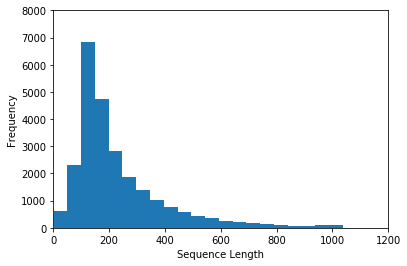

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(numWords, 50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.axis([0, 1200, 0, 8000])
plt.show()

Looking at this, 250 seems a good choice.

In [19]:
maxSeqLength = 250

## Mapping words to indexes

In this section we map words to indexes using our wordsList variable.

First we do it for a specific file.

In [20]:
fname = positiveFiles[3] #Can use any valid index (not just 3)
with open(fname) as f:
    for lines in f:
        print(lines)
        exit

An excellent movie about two cops loving the same woman. One of the cop (Périer) killed her, but all the evidences seems to incriminate the other (Montand). The unlucky Montand doesnt know who is the other lover that could have killed her, and Périer doesnt know either that Montand had an affair with the girl. Montand must absolutely find the killer...and what a great ending! Highly recommended.


Removes punctuation, parentheses, question marks, etc., and leaves only alphanumeric characters

In [21]:
import re
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

def cleanSentences(string):
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

In [22]:
firstFile = np.zeros((maxSeqLength), dtype='int32')
with open(fname) as f:
    indexCounter = 0
    line=f.readline()
    cleanedLine = cleanSentences(line)
    split = cleanedLine.split()
    for word in split:
        try:
            firstFile[indexCounter] = wordsList.index(word)
        except ValueError:
            firstFile[indexCounter] = 399999 #Vector for unknown words
        indexCounter = indexCounter + 1
firstFile

array([    29,   4345,   1005,     59,     55,  12193,   8842,      0,
          215,    787,     48,      3,      0,  10417, 388445,    256,
           71,     34,     64,      0,  47019,   1348,      4,  59799,
            0,     68, 105903,      0,  20938, 105903, 136283,    346,
           38,     14,      0,     68,   8410,     12,     94,     33,
          256,     71,      5, 388445, 136283,    346,    900,     12,
       105903,     40,     29,   4160,     17,      0,   1749, 105903,
          390,   3960,    596,      0, 399999,    102,      7,    353,
         1945,   1786,   3885,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

Now for all the files:

In [23]:
#ids = np.zeros((numFiles, maxSeqLength), dtype='int32')
#fileCounter = 0
#for pf in positiveFiles:
#    with open(pf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1

In [24]:
#for nf in negativeFiles:
#    with open(nf, "r") as f:
#        indexCounter = 0
#        line=f.readline()
#        cleanedLine = cleanSentences(line)
#        split = cleanedLine.split()
#        for word in split:
#            try:
#                ids[fileCounter][indexCounter] = wordsList.index(word)
#            except ValueError:
#                ids[fileCounter][indexCounter] = 399999 #Vector for unkown words
#            indexCounter = indexCounter + 1
#            if indexCounter >= maxSeqLength:
#                break
#        fileCounter = fileCounter + 1 

In [25]:
#Pass into embedding function and see if it evaluates. 

#np.save('idsMatrix', ids)

ids = np.load('idsMatrix.npy')

## Creating batching functions

In this section we create two functions which will help feeding the model with batches of samples.

In [26]:
from random import randint

Personnaly I don't like very much this implementation as it implies that we cannot define clear periods over which we go through all the data one and only one time. This is a point I would like to improve.

In [27]:
def getTrainBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        if (i % 2 == 0): 
            num = randint(1,11499)
            labels.append([1,0])
        else:
            num = randint(13499,24999)
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

In [28]:
def getTestBatch():
    labels = []
    arr = np.zeros([batchSize, maxSeqLength])
    for i in range(batchSize):
        num = randint(11499,13499)
        if (num <= 12499):
            labels.append([1,0])
        else:
            labels.append([0,1])
        arr[i] = ids[num-1:num]
    return arr, labels

## Definition of the model

In [29]:
batchSize = 24
lstmUnits = 64
numClasses = 2

In [30]:
import tensorflow as tf
tf.reset_default_graph()

These placeholders are here to take the input of the model (labels and samples turned into arrays of indices).

In [31]:
labels = tf.placeholder(tf.float32, [batchSize, numClasses])
input_data = tf.placeholder(tf.int32, [batchSize, maxSeqLength])

Then we embed the indices into vectors. The next cell is commented out because I think that it is useless. It was in the tutorial but I suspect that its author forgot to remove it.
As explained in the tutorial, we were using pretrained embeddings where vectors have length 50. But here numDimensions are of length 300. And in the following cell, 'data' defined again... I ran the notebook with and without it and it gives similar results so I commented it out.

In [32]:
#data = tf.Variable(tf.zeros([batchSize, maxSeqLength, numDimensions]),dtype=tf.float32)

In [33]:
data = tf.nn.embedding_lookup(wordVectors, input_data)

The following cell is a fix comming from
https://github.com/tgjeon/TensorFlow-Tutorials-for-Time-Series/issues/2
If I don't put it, errors appear in the cell after this one.

In [34]:
data = tf.cast(data, tf.float32)

Next we define the LSTM with dropout layer. According to the tutorial, the parameter lstmUnits needs some tuning to find the optimal value.

In [35]:
lstmCell = tf.contrib.rnn.BasicLSTMCell(lstmUnits)
lstmCell = tf.contrib.rnn.DropoutWrapper(cell=lstmCell, output_keep_prob=0.75)

Instructions for updating:
Use the retry module or similar alternatives.


If I understood it right, 'value' in the next cell represents the outputs of the lstm (for each sample of the batch and each word of each sample). According to the documentation it should have dimensions equal to [batch_size, max_time, cell.output_size].

In [36]:
value, _ = tf.nn.dynamic_rnn(lstmCell, data, dtype=tf.float32)

Next we add some afine transformation.

In [37]:
weight = tf.Variable(tf.truncated_normal([lstmUnits, numClasses]))
bias = tf.Variable(tf.constant(0.1, shape=[numClasses]))

If I'm not mistaken the next cell swaps the two first dimensions so it has dimensions [max_time, batch_size, cell.output_size].

In [38]:
value = tf.transpose(value, [1, 0, 2])

If I'm not mistaken the next cell slices the part of the output which corresponds to the last output of the lstm, or in other words the output corresponding to the last word for every sample (if I'm right we used 0 padding and cut everything which goes beyound 250 words, so technically it is the 250th output). My guess is that last has dimensions [batch_size, cell.output_size] which we can then use to do matrix multiplication with weight which has dimensions [cell.output_size, numClasses] (remember that cell.output_size=lstmUnits).

In [39]:
last = tf.gather(value, int(value.get_shape()[0]) - 1)

In [40]:
prediction = (tf.matmul(last, weight) + bias)

Next we compute accuracy.

In [41]:
correctPred = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correctPred, tf.float32))

Next we compute the cross-entropy loss using the logits (i.e. unnormalized probabilities), and we define the optimizer. Note that I replaced tf.nn.softmax_cross_entropy_with_logits (as in the original script) by tf.nn.softmax_cross_entropy_with_logits_v2 as indicated by a warning.

In [42]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=labels))
optimizer = tf.train.AdamOptimizer().minimize(loss)

The next cell allows us to use TensorBoard to visualize the loss and accuracy.

In [43]:
import datetime

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
merged = tf.summary.merge_all()
logdir = "tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/"
writer = tf.summary.FileWriter(logdir, sess.graph)

## Training

The number of iterations in the tutorial was 100K but it seems a lot. I will start with smaller values (1k, 10K) and see how it goes.

In [44]:
iterations = 1000

According to the author of the tutorial I'm copying, the training takes a lot of time. For this reason, he uses a pretrained model. But he provides the (commented) code for the training, which is displayed in the next cell.

In [45]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

In [46]:
for i in range(iterations):
    #Next Batch of reviews
    nextBatch, nextBatchLabels = getTrainBatch();
    sess.run(optimizer, {input_data: nextBatch, labels: nextBatchLabels})

    #Write summary to Tensorboard
    if (i % 50 == 0):
        summary = sess.run(merged, {input_data: nextBatch, labels: nextBatchLabels})
        writer.add_summary(summary, i)

    #Save the network every 10,000 training iterations
    if (i % 10000 == 0 and i != 0):
        save_path = saver.save(sess, "models/pretrained_lstm.ckpt", global_step=i)
        print("saved to %s" % save_path)
writer.close()

## TensorBoard

The author of the tutorial also mentions the possibility of tracking the progress of the model on TensorBoard by entering "tensorboard --logdir=tensorboard" in a terminal, and visiting http://localhost:6006/ with a browser.

## Using a pretrained model

After one has trained a first time the model, one can reuse it during the next executions.

In [47]:
#sess = tf.InteractiveSession()
#saver = tf.train.Saver()
#saver.restore(sess, tf.train.latest_checkpoint('models'))

## Testing our model on test data

To make sure one improves the quality of the model without overfitting, one has to test it agains test data. In the tutorial, they advise to alternate training phases on training data and testing phases on test data, and stop when the accuracy on test data starts decreasing.

In [48]:
iterations = 30
for i in range(iterations):
    nextBatch, nextBatchLabels = getTestBatch();
    print("Accuracy for this batch:", (sess.run(accuracy, {input_data: nextBatch, labels: nextBatchLabels})) * 100)

Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 66.66666865348816
Accuracy for this batch: 50.0
Accuracy for this batch: 62.5
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 37.5
Accuracy for this batch: 58.33333134651184
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 62.5
Accuracy for this batch: 50.0
Accuracy for this batch: 66.66666865348816
Accuracy for this batch: 66.66666865348816
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 41.66666567325592
Accuracy for this batch: 66.66666865348816
Accuracy for this batch: 45.83333432674408
Accuracy for this batch: 62.5
Accuracy for this batch: 50.0
Accuracy for this batch: 50.0
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 54.16666865348816
Accuracy for this batch: 54.1